In [1]:
#Loads modules
import torch as t
import matplotlib.pyplot as plt

import os

import sys
dir_path = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(dir_path,'scripts'))

import json

import importlib
import Systems as Systems
import Plotting as Plotting
import Training as Training
import Controls as Controls
import Evolvers as Evolvers

In [2]:
experiment = "Flensmon1D_0"

In [41]:
#Loads the params_dict for the experiment
exp_path = os.path.join(dir_path,"Experiments",experiment)

params_filepath = os.path.join(exp_path,"Parameters.json")
with open(params_filepath) as json_file:
    params_dict = json.load(json_file)

params_dict.update({"exp_path":exp_path})

tensor([[ 8.0945e-03, -7.3259e-03,  2.0238e-03,  ..., -5.5293e-06,
         -5.2406e-06, -5.2722e-06],
        [ 8.1100e-03, -7.3573e-03,  2.0825e-03,  ..., -5.5442e-06,
         -5.2536e-06, -5.2843e-06],
        [ 8.1384e-03, -7.3715e-03,  2.1239e-03,  ..., -5.5544e-06,
         -5.2666e-06, -5.3011e-06],
        ...,
        [-8.1315e-03,  7.3353e-03, -2.0851e-03,  ...,  5.5442e-06,
          5.2527e-06,  5.2853e-06],
        [-8.0730e-03,  7.3479e-03, -2.0212e-03,  ...,  5.5311e-06,
          5.2406e-06,  5.2741e-06],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])


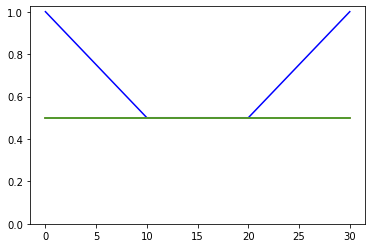

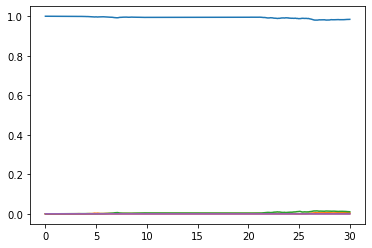

In [107]:
importlib.reload(Systems)
importlib.reload(Plotting)
importlib.reload(Training)
importlib.reload(Controls)
importlib.reload(Evolvers)

class Flensmon_1D(t.nn.Module, Systems.Periodic_System, Controls.CauchyPulse, Evolvers.ETrotter, Training.Trainer, Plotting.Plotter):
    def __init__(self,params_dict):
        super().__init__()
        self.params_dict = params_dict
        super(t.nn.Module,self).__init__()
        return
    
    def forward(self):
        H = self.get_H(self.activation_func(self.times),self.get_control())
        self.latest_matrix_exp = t.matrix_exp(-1j*H*self.dt)
        # self.latest_matrix_exp = self.basis_change@t.matrix_exp(-1j*H*self.dt)
        return t.linalg.multi_dot(list(mat for mat in self.latest_matrix_exp.flip(0)))

    def V(self, alphas, control):
        return self.EJ*(-self.cos_mat.repeat((alphas.shape[0],1,1)) \
                            + alphas.view(-1,1,1)/2*self.cos2_mat \
                            + control.view(-1,1,1)*self.q_mat)

obj = Flensmon_1D(params_dict)
# obj.plot_potential()
obj.plot_activation_func()
obj.plot_occupancy(indices=[0,1,2,4])

In [83]:
tmp = t.randint(0,4,(3,2))
t.ones((3,2,2))*tmp.unsqueeze(1), tmp

(tensor([[[2., 2.],
          [2., 2.]],
 
         [[3., 1.],
          [3., 1.]],
 
         [[2., 2.],
          [2., 2.]]]),
 tensor([[2, 2],
         [3, 1],
         [2, 2]]))

In [53]:
(obj.U0s[1:].adjoint()@obj.U0s[:-1])[:,[_ for _ in range(obj.NHilbert)],[_ for _ in range(obj.NHilbert)]].angle()

tensor([[ 8.0945e-03, -7.3259e-03,  2.0238e-03,  ..., -5.5293e-06,
         -5.2406e-06, -5.2722e-06],
        [ 8.1100e-03, -7.3573e-03,  2.0825e-03,  ..., -5.5442e-06,
         -5.2536e-06, -5.2843e-06],
        [ 8.1384e-03, -7.3715e-03,  2.1239e-03,  ..., -5.5544e-06,
         -5.2666e-06, -5.3011e-06],
        ...,
        [-8.1168e-03,  7.3956e-03, -2.1220e-03,  ...,  5.5525e-06,
          5.2657e-06,  5.2983e-06],
        [-8.1315e-03,  7.3353e-03, -2.0851e-03,  ...,  5.5442e-06,
          5.2527e-06,  5.2853e-06],
        [-8.0730e-03,  7.3479e-03, -2.0212e-03,  ...,  5.5311e-06,
          5.2406e-06,  5.2741e-06]])

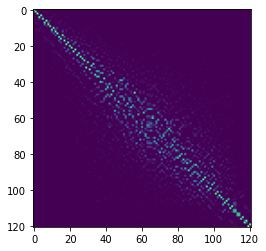

In [23]:
H1 = obj.get_H().squeeze()
H05 = obj.get_H(t.tensor([0.5])).squeeze()
E1, V1 = t.linalg.eigh(H1)
E05, V05 = t.linalg.eigh(H05)

plt.imshow((V05.adjoint()@V1).abs())

In [202]:
# plt.imshow((obj.U0dot.adjoint()@obj.U0dot).abs()[0])

tmp = obj.latest_matrix_exp.flip(0).detach()
# (tmp[1:]@tmp[:-1]).abs().diagonal(offset=0,dim1=-2,dim2=-1).sum(dim=-1)
empty = t.zeros(tmp.shape,dtype=t.cfloat)
empty[0] = tmp[0]
for i in range(1,tmp.shape[0]):
    empty[i] = tmp[i]@empty[i-1]
# plt.imshow((tmp[1:]@tmp[:-1]).abs()[4])

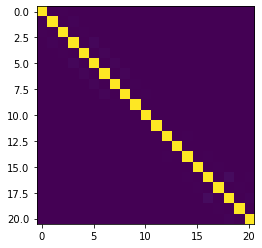

In [203]:
plt.imshow(empty.abs()[100])

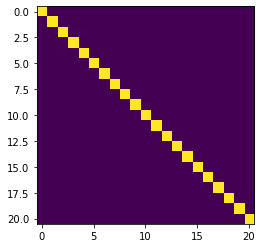

In [99]:
mask = ((obj.U0s[:-1].adjoint()@obj.U0s[1:]).abs().diagonal(offset=0,dim1=-2,dim2=-1).sum(dim=-1)<20.9)

plt.imshow((obj.U0s[:-1].adjoint()@obj.U0s[1:]).abs()[3])
# (obj.U0s[:-1].adjoint()@obj.U0s[1:]).abs().diagonal(offset=0,dim1=-2,dim2=-1).sum(dim=-1)

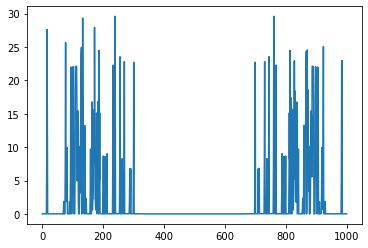

In [454]:
plt.plot([t.trace(mat) for mat in (obj.U0s.adjoint()@obj.U0dot[:,:,:4]).abs()])

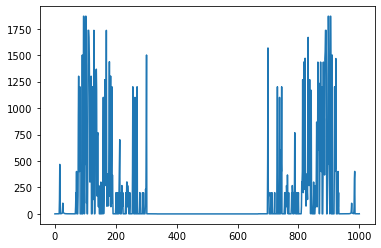

In [453]:
# obj.U0s.flip(0)[(obj.get_occupancy()[0]<0.9)].abs()
plt.plot(obj.U0dot.abs().sum(1).sum(1))

In [129]:
obj.minimize(0.01,50)

initial loss: 0.15132419764995575
Ended at step: 508, with loss: 0.1512138545513153 and runtime: 25.685275316238403


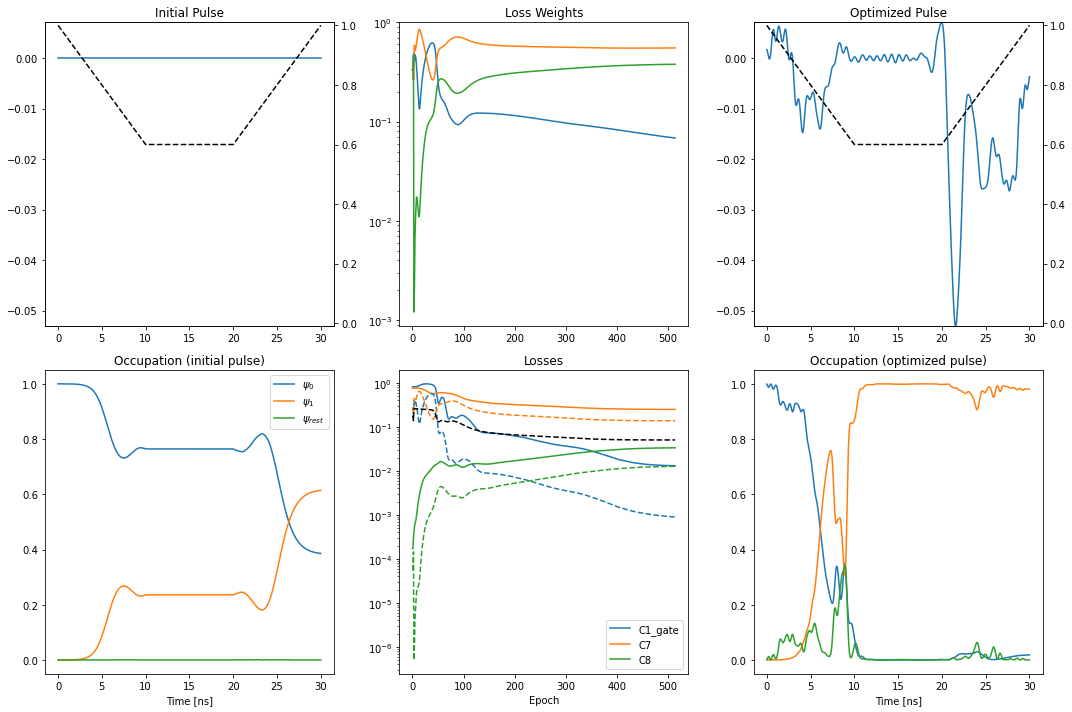

In [132]:
obj.plot_run(save=False,fig_name="CauchyPulse_RampPulse_gate.pdf")

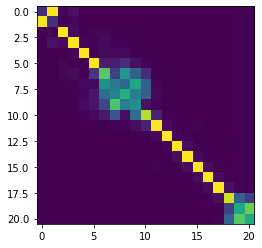

In [138]:
plt.imshow((obj.eigvecs.adjoint()@obj().detach()@obj.eigvecs).abs())

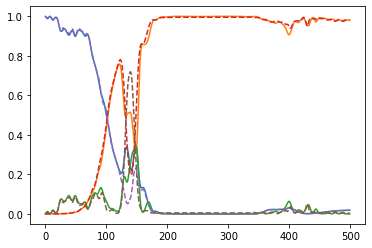

In [131]:
occ_0 = obj.get_occupancy().detach()
occ_1 = obj.get_occupancy(init_ind=1).detach()

fig, ax = plt.subplots()
ax.plot(occ_0.T)
ax.plot(occ_1.T,linestyle='--')

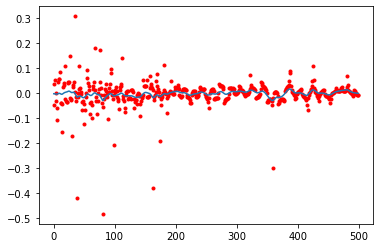

In [86]:
fig, ax = plt.subplots()

heights = obj.heights.detach()

weights = obj.height_weights

ax.plot(heights,'r.')
ax.plot(t.sum(heights*weights,1))

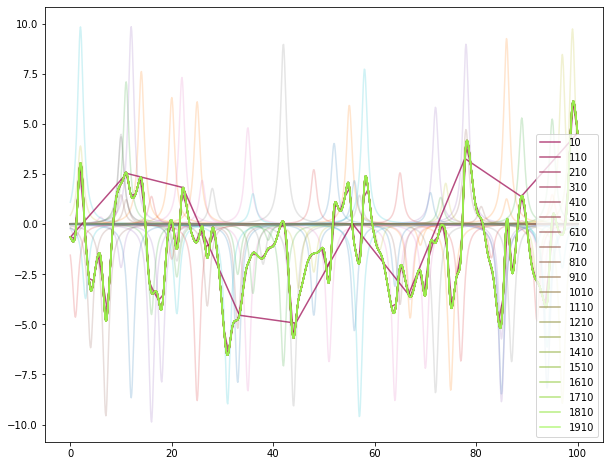

In [80]:
L = 100
N = 100
centers = t.randint(0,L,(1,N)).squeeze()
heights = (t.rand(N)-0.5)*20

fig, ax = plt.subplots(figsize=(10,8))

tmp = t.linspace(0,100,1000)
dists = (tmp.view(-1,1) - centers.view(1,-1))**2/0.5
ax.plot(tmp,heights/(1+dists),alpha=0.2)

for Ntmp in range(10,2000,100):
    tmp = t.linspace(0,L,Ntmp)
    dists = (tmp.view(-1,1) - centers.view(1,-1))**2/0.5
    w = 1/(1+dists.T)/t.sum(1/(1+dists),1)
    ax.plot(tmp,t.sum(heights*w.T,1),c=(0.6,Ntmp/2000,0.3),label=Ntmp,alpha=0.7)

ax.legend()


tensor(4.0000, dtype=torch.float64)

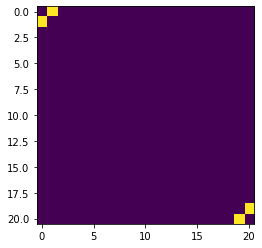

In [594]:
plt.imshow(t.abs(obj.cos_mat@obj.cos2_mat - obj.cos2_mat@obj.cos_mat))
t.abs(obj.cos_mat@obj.cos2_mat - obj.cos2_mat@obj.cos_mat).sum()

In [485]:
tmp = t.tensor([[0,1,0],[1,0,1],[0,1,0]])
tmp = t.tensor([[0,0,1],[0,0,0],[1,0,0]])
A=2.
t.matrix_exp(-1j*0.1*A*tmp)

tensor([[0.9801+0.0000j, 0.0000+0.0000j, 0.0000-0.1987j],
        [0.0000+0.0000j, 1.0000+0.0000j, 0.0000+0.0000j],
        [0.0000-0.1987j, 0.0000+0.0000j, 0.9801+0.0000j]])

In [486]:
eigvals, eigvecs = t.linalg.eig(t.matrix_exp(-1j*0.1*tmp))
t.diag(eigvals)**A
eigvecs@t.diag(eigvals)**A@eigvecs.adjoint()

tensor([[ 9.8007e-01-4.8507e-08j,  0.0000e+00+0.0000e+00j,
          4.9631e-08-1.9867e-01j],
        [ 0.0000e+00+0.0000e+00j,  1.0000e+00+0.0000e+00j,
          0.0000e+00+0.0000e+00j],
        [-4.6335e-08-1.9867e-01j,  0.0000e+00+0.0000e+00j,
          9.8007e-01-7.1731e-08j]])

In [516]:
t.isin(0,t.tensor([0.000001,2,3]))

tensor(False)

In [540]:
obj.EJ

62.83185307179586

In [539]:
t.pow(t.diag(t.tensor([1e-12,2,3])),t.tensor([0,2,3]).view(3,1,1)+1e-12)

tensor([[[1.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 1.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 1.0000e+00]],

        [[1.0000e-24, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 4.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 9.0000e+00]],

        [[1.0000e-36, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 8.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 2.7000e+01]]])

In [496]:
t.diag(t.tensor([1,2,3])).view(3,3)**(t.tensor([0,2,3]).view(3,1,1))

tensor([[[ 1,  1,  1],
         [ 1,  1,  1],
         [ 1,  1,  1]],

        [[ 1,  0,  0],
         [ 0,  4,  0],
         [ 0,  0,  9]],

        [[ 1,  0,  0],
         [ 0,  8,  0],
         [ 0,  0, 27]]])

In [484]:
Y = t.zeros(6,2,2)
Y[0::2] = A
Y[1::2] = B
Y[3]

tensor([[5., 6.],
        [7., 8.]])

In [624]:
t.tensor([0.5,0.1,0.2])*t.pow(t.tensor([0.,2,3]),t.tensor([0,1,2,4]).view(-1,1))

tensor([[ 0.5000,  0.1000,  0.2000],
        [ 0.0000,  0.2000,  0.6000],
        [ 0.0000,  0.4000,  1.8000],
        [ 0.0000,  1.6000, 16.2000]])

In [566]:
t.diag_embed(t.pow(t.arange(0.,3,1),t.tensor([0,2,3,5]).view(-1,1)))

torch.Size([4, 3, 3])

In [628]:
t.diag(t.tensor([0,2,3])).repeat(5,1,1).shape

torch.Size([5, 3, 3])

In [542]:
t.matrix_exp(t.diag(t.tensor([0.,2,3])))

tensor([[ 1.0000,  0.0000,  0.0000],
        [ 0.0000,  7.3891,  0.0000],
        [ 0.0000,  0.0000, 20.0855]])

In [595]:
v1, e1 = t.linalg.eigh(obj.cos_mat)
v2, e2 = t.linalg.eigh(obj.cos2_mat)

In [607]:
Q = t.vstack([t.hstack([obj.cos_mat,t.zeros(21,21)]),t.hstack([obj.cos2_mat,t.zeros(21,21)])])
t.linalg.solve(Q,t.vstack([v1.view(-1,1),v2.view(-1,1)]))

RuntimeError: input dtype ComplexDouble does not match other dtype Double

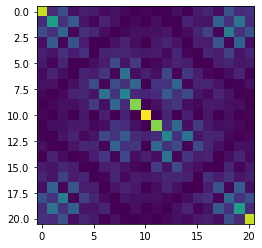

In [592]:
plt.imshow((e1@obj.cos2_mat@e1.adjoint()).abs())

In [633]:
tmp = t.randint(0,10,(4,2,2))
tmp@t.tensor([[0,1],[1,0]]), tmp

(tensor([[[8, 1],
          [4, 8]],
 
         [[0, 0],
          [7, 0]],
 
         [[1, 3],
          [2, 5]],
 
         [[8, 5],
          [9, 2]]]),
 tensor([[[1, 8],
          [8, 4]],
 
         [[0, 0],
          [0, 7]],
 
         [[3, 1],
          [5, 2]],
 
         [[5, 8],
          [2, 9]]]))

In [642]:
t.randint(0,4,(4,2,2))@t.randint(0,4,(4,2,2))

tensor([[[ 7, 13],
         [ 3,  5]],

        [[12,  9],
         [ 3,  0]],

        [[11,  9],
         [ 0,  0]],

        [[ 1,  1],
         [ 0,  6]]])

In [645]:
params_dict['NTrot'] = 2000

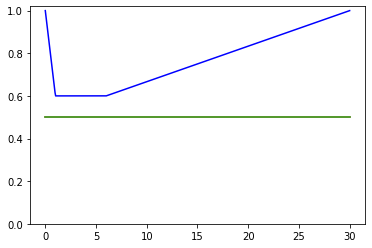

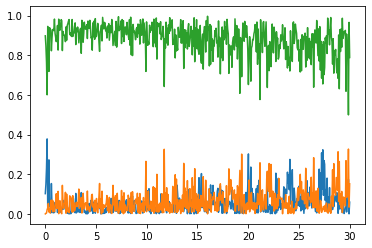

In [30]:
importlib.reload(Systems)
importlib.reload(Plotting)
importlib.reload(Training)
importlib.reload(Controls)

class Flensmon_1D(t.nn.Module, Systems.Periodic_System, Controls.CauchyPulse, Training.Trainer, Plotting.Plotter):
    def __init__(self,params_dict):
        super().__init__()
        self.params_dict = params_dict
        super(t.nn.Module,self).__init__()
        return

    def forward(self):
        alphas = self.activation_func(self.times).flip(0)
        pulse = self.get_control().flip(0)
        # M2s = self.t1*t.pow(self.t2,pulse.view(-1,1))
        # matrices = t.zeros((2*self.NTrot,self.NHilbert,self.NHilbert)).type(t.complex128)
        # matrices[0::2] = t.diag_embed(self.t1*t.pow(self.t2,pulse.view(-1,1)))
        # matrices[1::2] = self.t3@t.diag_embed(t.pow(self.t4,alphas.view(-1,1)))@self.u4_adj
        M1s = t.diag_embed(self.t1*t.pow(self.t2,pulse.view(-1,1)))
        M2s = self.t3@t.diag_embed(t.pow(self.t4,alphas.view(-1,1)))@self.u4_adj
        self.latest_matrix_exp = M1s@M2s
        return t.linalg.multi_dot(list(mat for mat in self.latest_matrix_exp))

    # def forward(self):
    #     H = self.get_H(self.activation_func(self.times).flip(0),self.get_control().flip(0))
    #     self.latest_matrix_exp = t.matrix_exp(-1j*H*self.dt)
    #     return t.linalg.multi_dot(list(mat for mat in self.latest_matrix_exp))

    def prepare_KinE(self):
        self.KinE = 4*self.params_dict['EC']*self.q_mat**2
        self.EJ = self.params_dict['EJ']

    def V(self, alphas, control):
        return self.EJ*(-self.cos_mat.repeat((alphas.shape[0],1,1)) \
                            + alphas.view(-1,1,1)/2*self.cos2_mat \
                            + control.flip(0).view(-1,1,1)*self.q_mat)

obj = Flensmon_1D(params_dict)
# obj.plot_potential()
obj.plot_activation_func()
obj.plot_occupancy()

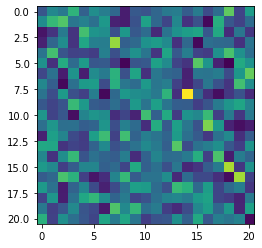

In [34]:
plt.imshow(obj().abs().detach())